# Universal and Untargeted Adversarial Examples on RobustBench CIFAR-10 Models

## Machine Learning Security Project 2 Overview

This project investigates the creation of **universal, untargeted adversarial examples** capable of fooling multiple robust image classification models simultaneously. Specifically, we focus on models trained on the **CIFAR-10** dataset under **L∞ threat model constraints**, as provided by the [RobustBench](https://robustbench.github.io/) benchmark.

The goals of the project are:
1. **Craft universal adversarial examples** that mislead an ensamble of 3 RobustBench models.
2. **Evaluate the transferability** of these adversarial examples across **seven additional models** from RobustBench.

We generate adversarial examples using an ensemble-based FGSM approach and assess how well these attacks generalize across different model architectures.

---

**Authors**:  
- Milena Leandri - ID: 70/90/00519  
- Alessandro Pruner - ID: 70/90/00502

## 🔧 Setup and Installation

We begin by installing RobustBench, a benchmark suite for evaluating adversarial robustness of models. This will allow us to load pretrained models for CIFAR-10.


In [ ]:
!pip install git+https://github.com/RobustBench/robustbench.git

  Cloning https://github.com/RobustBench/robustbench.git to /tmp/pip-req-build-hjk0cjzl
  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git /tmp/pip-req-build-hjk0cjzl
  Resolved https://github.com/RobustBench/robustbench.git to commit 78fcc9e48a07a861268f295a777b975f25155964
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/fra31/auto-attack.git (to revision a39220048b3c9f2cca9a4d3a54604793c68eca7e) to /tmp/pip-install-u7qklrkm/autoattack_dd9f8203fb1449aaab88f85d42adf397
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack.git /tmp/pip-install-u7qklrkm/autoattack_dd9f8203fb1449aaab88f85d42adf397
  Running command git rev-parse -q --verify 'sha^a39220048b3c9f2cca9a4d3a54604793c68eca7e'
  Running command git fetch -q https://github.com/fra31/auto-attack.git a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Resolved https://github.com/fra31/auto-attack.git to commit a39220048b3c9f2cca9a4

## Imports and Configuration

Here we import necessary libraries, define global variables, and set up utility functions such as seed fixing and ensemble prediction. We will use 1000 samples from the CIFAR-10 test set.


In [ ]:
# Library imports
import os
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Subset
from robustbench.utils import load_model
import matplotlib.pyplot as plt

In [ ]:
# Global Variables
seed = 42
num_samples = 1000 # Number of samples to extract from the Cifar10 dataset
batch_size = 1
final_adversarials = list() # This list will contain the adversarials generated e.g. --> (adv, y_true)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils functions
def set_seed(seed):
    '''
    Sets the random seed for reproducibility
    '''
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def margin_loss(logits, correct_label):
    '''
    Calculates the margin loss
    '''
    logits = logits.squeeze()

    correct_logit = logits[correct_label.item()]

    logits_copy = logits.clone().detach()
    logits_copy[correct_label.item()] = -torch.inf

    highest_wrong_logit = torch.max(logits_copy)

    margin_loss = highest_wrong_logit - correct_logit
    return margin_loss


def predict_with_ensemble(models, x):
    '''
    Performs prediction using an ensemble of models

    This function averages the logits from multiple models to make a final
    prediction
    '''
    predictions = []
    with torch.no_grad():
        for m in models:
            predictions.append(m(x))
        avg_logits = torch.stack(predictions).mean(dim=0)

    y_pred = avg_logits.argmax().item()
    return y_pred, avg_logits

In [ ]:
# Loading the 3 models from RobustBench
models = [
    load_model(model_name='Zhang2019You', dataset='cifar10', threat_model='Linf').to(device).eval(),
    load_model(model_name='Xu2023Exploring_WRN-28-10', dataset='cifar10', threat_model='Linf').to(device).eval(),
    load_model(model_name='Gowal2021Improving_28_10_ddpm_100m', dataset='cifar10', threat_model='Linf').to(device).eval()
]

## Dataset Preparation

We use the CIFAR-10 test set and extract a subset of 1000 samples. The dataset is transformed to tensors and loaded into batches of size 1.

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
cifar10_dataset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform)

cifar10_subset = Subset(cifar10_dataset, range(num_samples)) # Subset of 1000 samples
data_loader = DataLoader(cifar10_subset, batch_size=batch_size)

## Adversarial Attack: FGSM over Ensemble

We define the FGSM (Fast Gradient Sign Method) to craft adversarial examples. Instead of targeting a single model, we aggregate logits from all three models in the ensemble to calculate the loss, ensuring that perturbations aim to fool all three simultaneously.

In [ ]:
def fgsm_ensemble(models, x, true_labels, epsilon):
    '''
    Generates an adversarial example using the Fast Gradient Sign Method (FGSM)
    with an ensemble of models

    This function leverages the gradients from an ensemble's combined loss
    to create an adversarial perturbation, aiming to fool the ensemble
    '''
    x_adv = x.clone().detach()
    x_adv.requires_grad = True

    logits_list = [model(x_adv) for model in models]

    stacked_logits = torch.stack(logits_list, dim=0)

    ensemble_logits = torch.mean(stacked_logits, dim=0)

    loss = margin_loss(ensemble_logits, true_labels)

    # Compute the gradient of the loss with respect to x_adv
    grad = torch.autograd.grad(loss, x_adv)[0]
    # Apply the FGSM perturbation: add epsilon times the sign of the gradient
    x_adv = x_adv.detach() + epsilon * torch.sign(grad.detach())
    # Clip the perturbed input to stay within the valid [0, 1]
    x_adv = torch.clamp(x_adv, 0, 1).detach()

    y_pred = predict_with_ensemble(models, x_adv)
    y_pred_0 = y_pred[0] # Extract the predicted class label

    return x_adv, y_pred_0

## Adversarial Examples Generation

We iterate over the 1000-sample subset and generate adversarial examples only for inputs that are **correctly classified by the ensemble**.

In [ ]:
# Statistics variables
total_adv_examples = 0 # Number of adversarials generated
excluded_adv_examples = 0 # Number of excluded samples

# Number of samples to plot
n_samples_to_plot = 5
# List containing the samples to plot (just for visualization)
samples_to_plot = list()

# Adversarials generation
# For each sample in the cifar10 subset
for (x, y_true) in data_loader:
    x, y_true = x.to(device), y_true.to(device)

    # The ensemble predict the sample label
    y_pred = predict_with_ensemble(models, x)
    y_pred_0 = y_pred[0]

    # If they already fail labeling the sample
    if y_pred_0 != y_true:
        # Increment of the excluded samples counter
        excluded_adv_examples += 1
        # We skip to the next sample (attack doesn't run for this sample)
        continue

    # FGSM attack with epsilon = 8/255
    x_adv, y_pred_adv = fgsm_ensemble(models, x, y_true, 8/255)

    # If the generated adv fools the ensemble
    if y_pred_adv != y_true:
        # The adv and it's true label are appended to the list of adversarials
        final_adversarials.append((x_adv, y_true.item()))
        total_adv_examples += 1
        # If we didn't reach the number of samples to plot, we add the clean sample
        # and the adversarial to the list
        if len(samples_to_plot) < n_samples_to_plot:
            samples_to_plot.append((x.cpu().squeeze(), x_adv.cpu().squeeze(), y_true.item(), y_pred_adv))

# Statistics print
print(f'{total_adv_examples} adversarial examples created, {excluded_adv_examples} samples have been excluded')

149 adversarial examples created, 75 samples have been excluded


## 🖼️ Visualizing Adversarial Perturbations

Below we display 5 adversarial examples alongside their clean counterparts and the perturbation maps.

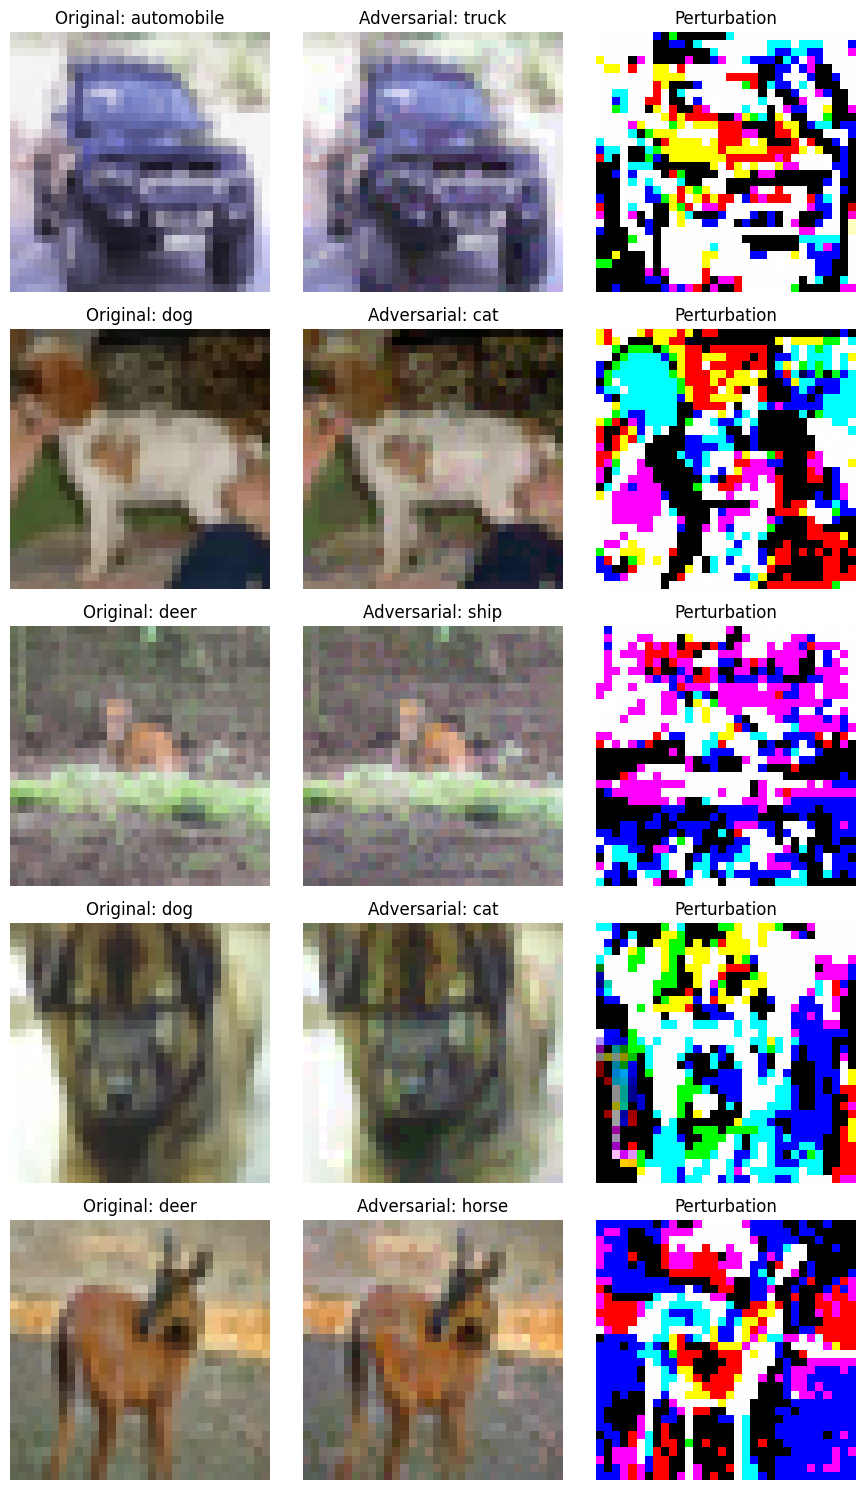

In [ ]:
# Classes of the Cifar10 dataset (useful for plot labels)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Plots
fig, axes = plt.subplots(5, 3, figsize=(9, 15))
for i, (orig, adv, true_idx, adv_idx) in enumerate(samples_to_plot):
    orig_img = orig.permute(1, 2, 0).numpy()
    adv_img  = adv.permute(1, 2, 0).numpy()
    perturb  = adv_img - orig_img
    pert_vis = (perturb - perturb.min()) / (perturb.max() - perturb.min() + 1e-12)

    # Title strings
    true_name = class_names[true_idx]
    adv_name  = class_names[adv_idx]

    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title(f'Original: {true_name}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(adv_img)
    axes[i, 1].set_title(f'Adversarial: {adv_name}')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(pert_vis)
    axes[i, 2].set_title('Perturbation')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

## Transferability Evaluation Setup

Now that we have generated adversarial examples that fool the 3-model ensemble, we assess their **transferability**. We test whether these adversarial examples can fool **seven other CIFAR-10 models** available on RobustBench.

In [ ]:
# List containing the model names (useful for statistics printing)
model_names = [
    'Huang2022Revisiting_WRN-A4',
    'Peng2023Robust',
    'Amini2024MeanSparse_Ra_WRN_70_16',
    'Sehwag2021Proxy_ResNest152',
    'Debenedetti2022Light_XCiT-L12',
    'Cui2023Decoupled_WRN-28-10',
    'Rebuffi2021Fixing_28_10_cutmix_ddpm'
]

# Loading the 7 models from RobustBench
transf_models = [
    load_model(model_name='Huang2022Revisiting_WRN-A4', dataset='cifar10', threat_model='Linf').to(device).eval(),
    load_model(model_name='Peng2023Robust', dataset='cifar10', threat_model='Linf').to(device).eval(),
    load_model(model_name='Amini2024MeanSparse_Ra_WRN_70_16', dataset='cifar10', threat_model='Linf').to(device).eval(),
    load_model(model_name='Sehwag2021Proxy_ResNest152', dataset='cifar10', threat_model='Linf').to(device).eval(),
    load_model(model_name='Debenedetti2022Light_XCiT-L12', dataset='cifar10', threat_model='Linf').to(device).eval(),
    load_model(model_name='Cui2023Decoupled_WRN-28-10', dataset='cifar10', threat_model='Linf').to(device).eval(),
    load_model(model_name='Rebuffi2021Fixing_28_10_cutmix_ddpm', dataset='cifar10', threat_model='Linf').to(device).eval()
]

In [ ]:
# Dictionary containing the model name as key and the attack success rate as value
model_scores = {name: 0.0 for name in model_names}

In [ ]:
# Utils functions
def predict(model, x, device):
    '''
    Performs inference with a given model on the input data.
    '''
    model.eval()
    preds = []

    with torch.no_grad():
        x = x.to(device)
        logits = model(x)
        predicted_classes = torch.argmax(logits, dim=1)
        preds = list(predicted_classes.cpu().numpy())

    return preds

## 📊 Measuring Transfer Success

For each of the 7 additional robust models, we evaluate how many of the ensemble-generated adversarial examples are misclassified.

In [ ]:
# Transferability evaluation

# For each model
for i, model in enumerate(transf_models):
    print(f'Evaluating model {model_names[i]}...')
    # Variable to keep track of the number of adversarials that fooled the model
    transfer_counter = 0

    # For each adversarial generated
    for x_adv, y_true in final_adversarials:
        model = model.to(device)
        # The model predicts on the adversarial sample
        pred = predict(model, x_adv, device)
        # If the model misclassifies the adversarial
        if pred[0] != y_true:
            # Increment the counter
            transfer_counter += 1

    # Computation of the success rate for the considered model
    success_rate = transfer_counter / len(final_adversarials)
    # Print statistics
    print(f'Transfer counter: {transfer_counter}, attack success rate: {success_rate}')
    # Save the metric in the dictionary
    model_scores[model_names[i]] = success_rate

Evaluating model Huang2022Revisiting_WRN-A4...
Transfer counter: 96, attack success rate: 0.6442953020134228
Evaluating model Peng2023Robust...
Transfer counter: 88, attack success rate: 0.5906040268456376
Evaluating model Amini2024MeanSparse_Ra_WRN_70_16...
Transfer counter: 87, attack success rate: 0.5838926174496645
Evaluating model Sehwag2021Proxy_ResNest152...
Transfer counter: 116, attack success rate: 0.7785234899328859
Evaluating model Debenedetti2022Light_XCiT-L12...
Transfer counter: 95, attack success rate: 0.6375838926174496
Evaluating model Cui2023Decoupled_WRN-28-10...
Transfer counter: 97, attack success rate: 0.6510067114093959
Evaluating model Rebuffi2021Fixing_28_10_cutmix_ddpm...
Transfer counter: 116, attack success rate: 0.7785234899328859


## Transferability Results

The bar plot below summarizes the **attack success rate** (fraction of adversarial examples that fooled each model) across all 7 models. Higher values indicate better transferability and lower model robustness against universal attacks.

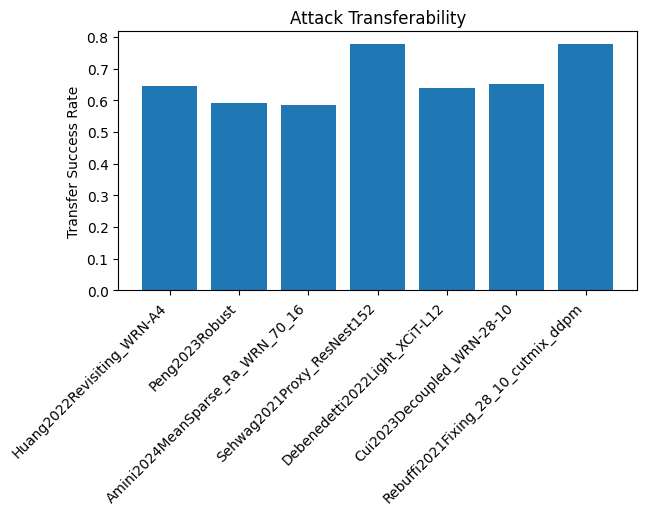

In [ ]:
# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar(model_scores.keys(), model_scores.values())
plt.xticks(rotation=45, ha='right')
plt.ylabel('Transfer Success Rate')
plt.title('Attack Transferability')

plt.tight_layout()
plt.show()